In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from diffusion_edf.graph_parser import RadiusBipartite
from diffusion_edf.gnn_data import FeaturedPoints, GraphEdge

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = 'cuda:0'
irreps = "1x0e+1x1e+1x2e"

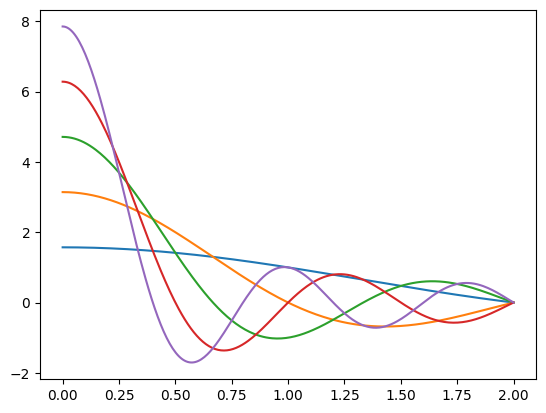

In [3]:
graph_parser = RadiusBipartite(
    r_cutoff = 2.,
    r_mincut_nonscalar_sh=0.2,
    length_enc_dim=5,
    irreps_sh=irreps,
).to(device)

graph_parser: RadiusBipartite = torch.jit.script(graph_parser)

###### Figure #######
x = torch.linspace(0.,graph_parser.edge_cutoff_ranges[-1], 300, device=device)
out: torch.Tensor = graph_parser.length_enc(x)
plt.plot(x.cpu(), out.cpu())

In [4]:
src_pcd = FeaturedPoints(x=torch.tensor([[0., 0., 0.],
                                         [0., 0., 1.],
                                         [0., 1., 0.]], device=device), f=torch.randn(3,3, device=device), b=torch.zeros(3, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.tensor([[0., 0., 0.15],
                                         [0., 0., 1.9]], device=device), f=torch.randn(2,3, device=device), b=torch.zeros(2, device=device, dtype=torch.long))

In [5]:
graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)
torch.stack([graph_edge.edge_src, graph_edge.edge_dst])
graph_edge.edge_scalars.shape
print(f"edge length: {graph_edge.edge_length}\n")
print(f"edge length rel: {graph_edge.edge_length / graph_parser.edge_cutoff_ranges[-1]}\n")
print(f"edge cutoff: {graph_edge.edge_weights}\n")
print(f"scalar norm: {graph_edge.edge_attr[...,0]}\n")
print(f"spin-1 norm: {graph_edge.edge_attr[...,1:4].norm(dim=-1)}\n")
print(f"spin-2 norm: {graph_edge.edge_attr[...,4:9].norm(dim=-1)}\n")

edge length: tensor([0.1500, 0.8500, 1.0112, 1.9000, 0.9000], device='cuda:0')

edge length rel: tensor([0.0750, 0.4250, 0.5056, 0.9500, 0.4500], device='cuda:0')

edge cutoff: tensor([1.0000, 1.0000, 1.0000, 0.2617, 1.0000], device='cuda:0')

scalar norm: tensor([1., 1., 1., 1., 1.], device='cuda:0')

spin-1 norm: tensor([1.0905, 1.7321, 1.7321, 1.7321, 1.7321], device='cuda:0')

spin-2 norm: tensor([1.4078, 2.2361, 2.2361, 2.2361, 2.2361], device='cuda:0')



In [6]:
graph_parser = RadiusBipartite(
    r_cutoff=[0.3, 0.5, 1.8, 2.0],
    length_enc_dim=5,
    irreps_sh=irreps,
).to(device)


graph_parser: RadiusBipartite = torch.jit.script(graph_parser)

In [7]:
graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)
torch.stack([graph_edge.edge_src, graph_edge.edge_dst])
graph_edge.edge_scalars.shape
print(f"edge length: {graph_edge.edge_length}\n")
print(f"edge length rel: {graph_edge.edge_length / graph_parser.edge_cutoff_ranges[-1]}\n")
print(f"edge cutoff: {graph_edge.edge_weights}\n")
print(f"scalar norm: {graph_edge.edge_attr[...,0]}\n")
print(f"spin-1 norm: {graph_edge.edge_attr[...,1:4].norm(dim=-1)}\n")
print(f"spin-2 norm: {graph_edge.edge_attr[...,4:9].norm(dim=-1)}\n")

edge length: tensor([0.8500, 1.0112, 1.9000, 0.9000], device='cuda:0')

edge length rel: tensor([0.4250, 0.5056, 0.9500, 0.4500], device='cuda:0')

edge cutoff: tensor([1.0000, 1.0000, 0.6875, 1.0000], device='cuda:0')

scalar norm: tensor([1., 1., 1., 1.], device='cuda:0')

spin-1 norm: tensor([1.7321, 1.7321, 1.7321, 1.7321], device='cuda:0')

spin-2 norm: tensor([2.2361, 2.2361, 2.2361, 2.2361], device='cuda:0')



# Speed Test

In [8]:
####### Warm Up #######
for _ in range(10):
    src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
    dst_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device) + 2., f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

In [16]:
src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device) + 2., f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))

for _ in tqdm(range(5000)):
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

100%|██████████| 5000/5000 [00:03<00:00, 1440.67it/s]


In [10]:
len(graph_edge.edge_src) # Graph size does not make big difference

50294

In [15]:
src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device) + 4., f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))

for _ in tqdm(range(5000)):
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

100%|██████████| 5000/5000 [00:03<00:00, 1526.75it/s]


In [12]:
len(graph_edge.edge_src) # Graph size does not make big difference

26

In [13]:
src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device) + 4., f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))

for _ in tqdm(range(5000)):
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd, max_neighbors=20)

100%|██████████| 5000/5000 [00:02<00:00, 1706.71it/s]


In [14]:
len(graph_edge.edge_src) # smaller max_neighbor => slightly faster (c.f. max_neighbors = 1000 is default)

92